In [1]:
MONK_TASK = 1
USER = "Nunzio"

In [2]:
import sys
import os
if (colab := 'google.colab' in sys.modules):
    from google.colab import drive
    drive.mount('/content/drive')
    BASE_PATH = "/content/drive/Shareddrives/Project_ML_23/" + USER + "/machine-learning-project"
    sys.path.insert(0,BASE_PATH)
    N_JOBS = 1
    sys.path.insert(0,BASE_PATH + "/src/utils")
    !pip install optuna
    !pip install scikit-learn
    !pip install scikeras
    TRAIN_DATA = os.path.join(BASE_PATH, 'datasets', 'monk',f'monks-{MONK_TASK}.train')
    TEST_DATA = os.path.join(BASE_PATH, 'datasets', 'monk',f'monks-{MONK_TASK}.test')
    IMAGES_FOLDER = os.path.join(BASE_PATH, 'images', 'monk',  f'task-{MONK_TASK}', 'neural_network')
    MODEL_FOLDER = os.path.join(BASE_PATH, 'trained_models', 'monk', f'task-{MONK_TASK}')
else :
    TRAIN_DATA = os.path.join('..', '..', '..', 'datasets', 'monk', f'monks-{MONK_TASK}.train')
    TEST_DATA = os.path.join('..', '..', '..', 'datasets', 'monk', f'monks-{MONK_TASK}.test')
    N_JOBS = -1
    IMAGES_FOLDER = os.path.join('..', '..', '..', 'images', 'monk', f'task-{MONK_TASK}', 'neural_network')
    MODEL_FOLDER = os.path.join('..', '..', '..', 'trained_models', 'monk', f'task-{MONK_TASK}')

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.4 MB/s eta 0:00:00


In [3]:
sys.path.append(BASE_PATH + "/src/utils")


import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns; sns.set_theme(style='darkgrid')

from utils import save_plot, set_random_state

set_random_state(42)

In [4]:
# To skip the first column (row indexes)
columns_to_read = list(range(1, 8))

df_train = pd.read_csv(TRAIN_DATA, header=None, usecols=columns_to_read, delimiter=' ')
df_test = pd.read_csv(TEST_DATA, header=None, usecols=columns_to_read, delimiter=' ')
df_train.head()

,1,2,3,4,5,6,7
0,1,1,1,1,1,3,1
1,1,1,1,1,1,3,2
2,1,1,1,1,3,2,1
3,1,1,1,1,3,3,2
4,1,1,1,2,1,2,1


In [5]:
features = ['feature_' + str(i) for i in range(1, 7)]

# Rename columns
new_column_names = ['class'] + features

df_train.columns = new_column_names
df_test.columns = new_column_names

df_train.head()

,class,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6
0,1,1,1,1,1,3,1
1,1,1,1,1,1,3,2
2,1,1,1,1,3,2,1
3,1,1,1,1,3,3,2
4,1,1,1,2,1,2,1


In [6]:
df_train_encoded = pd.get_dummies(df_train, columns=features)
df_test_encoded = pd.get_dummies(df_test, columns=features)

df_train_encoded, df_test_encoded = df_train_encoded.align(df_test_encoded, join='inner', axis=1)

df_train_encoded.head()

,class,feature_1_1,feature_1_2,feature_1_3,feature_2_1,feature_2_2,feature_2_3,feature_3_1,feature_3_2,feature_4_1,feature_4_2,feature_4_3,feature_5_1,feature_5_2,feature_5_3,feature_5_4,feature_6_1,feature_6_2
0,1,1,0,0,1,0,0,1,0,1,0,0,0,0,1,0,1,0
1,1,1,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,1
2,1,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0
3,1,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1
4,1,1,0,0,1,0,0,0,1,1,0,0,0,1,0,0,1,0


In [7]:
features = df_train_encoded.columns.difference(['class'])

X_train = df_train_encoded[features].to_numpy()
y_train = df_train_encoded['class'].to_numpy()

X_test = df_test_encoded[features].to_numpy()
y_test = df_test_encoded['class'].to_numpy()

# Create model

In [8]:
from keras.src.regularizers import l2
from keras.src.optimizers import Adam, SGD
from keras.models import Sequential
from keras.layers import Dense

def create_model(architecture=(8,), optimizer='adam', learning_rate=0.001, lambda_value=0.1, momentum=0.9):
    model = Sequential()
    model.add(Dense(units=architecture[0], input_dim=X_train.shape[1], activation='relu',#relu
                    kernel_regularizer=l2(lambda_value)))

    for units in architecture[1:]:
        model.add(Dense(units=units, activation='relu', kernel_regularizer=l2(lambda_value))) #sigmoid

    model.add(Dense(1, activation='sigmoid'))

    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate, beta_1=momentum)
    else:
        opt = SGD(learning_rate=learning_rate, momentum=momentum)

    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['binary_accuracy']) #'mse'
    return model


In [9]:
from scikeras.wrappers import KerasClassifier

model = KerasClassifier(create_model, verbose=0)

In [10]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'model__architecture': [
        (8), (8, 8), (8, 8, 8), (8,8,8,8)
    ],
    'model__optimizer': ['sgd'],
    'model__learning_rate': [0.1, 0.3, 0.5],
    'model__momentum': [0.6, 0.8, 0.9],
    'model__lambda_value': [0.01],
    'epochs': [200],
    'batch_size': [8]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    n_jobs=N_JOBS,
    verbose=2,
    scoring='accuracy'
)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END batch_size=8, epochs=200, model__architecture=8, model__lambda_value=0.01, model__learning_rate=0.1, model__momentum=0.6, model__optimizer=sgd; total time=   0.2s
[CV] END batch_size=8, epochs=200, model__architecture=8, model__lambda_value=0.01, model__learning_rate=0.1, model__momentum=0.6, model__optimizer=sgd; total time=   0.0s
[CV] END batch_size=8, epochs=200, model__architecture=8, model__lambda_value=0.01, model__learning_rate=0.1, model__momentum=0.6, model__optimizer=sgd; total time=   0.0s
[CV] END batch_size=8, epochs=200, model__architecture=8, model__lambda_value=0.01, model__learning_rate=0.1, model__momentum=0.6, model__optimizer=sgd; total time=   0.0s
[CV] END batch_size=8, epochs=200, model__architecture=8, model__lambda_value=0.01, model__learning_rate=0.1, model__momentum=0.6, model__optimizer=sgd; total time=   0.0s
[CV] END batch_size=8, epochs=200, model__architecture=8, model__lambda_value=

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
45 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1491, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/w

GridSearchCV(cv=5,
             estimator=KerasClassifier(model=<function create_model at 0x7b6584c8c9d0>, verbose=0),
             n_jobs=1,
             param_grid={'batch_size': [8], 'epochs': [200],
                         'model__architecture': [8, (8, 8), (8, 8, 8),
                                                 (8, 8, 8, 8)],
                         'model__lambda_value': [0.01],
                         'model__learning_rate': [0.1, 0.3, 0.5],
                         'model__momentum': [0.6, 0.8, 0.9],
                         'model__optimizer': ['sgd']},
             scoring='accuracy', verbose=2)

In [11]:
from sklearn.metrics import accuracy_score, classification_report

final_model = grid_search.best_estimator_
y_pred = final_model.predict(X_test)

print('Best parameters: ', grid_search.best_params_)
print('Best accuracy: ', grid_search.best_score_)
print('Test set accuracy: ', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Best parameters:  {'batch_size': 8, 'epochs': 200, 'model__architecture': (8, 8), 'model__lambda_value': 0.01, 'model__learning_rate': 0.1, 'model__momentum': 0.6, 'model__optimizer': 'sgd'}
Best accuracy:  0.8283333333333334
Test set accuracy:  1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       216
           1       1.00      1.00      1.00       216

    accuracy                           1.00       432
   macro avg       1.00      1.00      1.00       432
weighted avg       1.00      1.00      1.00       432



# Learning curve

In [12]:
best_params = grid_search.best_params_

best_model = create_model(architecture=best_params['model__architecture'],
                          optimizer=best_params['model__optimizer'],
                          learning_rate=best_params['model__learning_rate'],
                          lambda_value=best_params['model__lambda_value'],
                          momentum=best_params['model__momentum'])

history = best_model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0, validation_split=0.1)

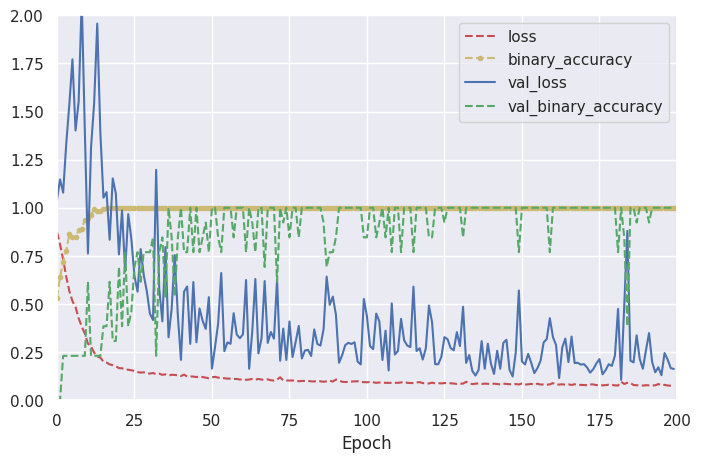

In [13]:
pd.DataFrame(history.history).plot(
    figsize=(8, 5),
    xlim=[0, 200],
    ylim=[0, 2],
    grid=True,
    xlabel='Epoch',
    style=['r--', 'y--.', 'b-', 'g--']
)

plt.show()

# Save model

In [14]:
from joblib import dump

model_path = os.path.join(MODEL_FOLDER, 'NN_model.joblib')
dump(final_model, model_path, compress=3)

['/content/drive/Shareddrives/Project_ML_23/Nunzio/machine-learning-project/trained_models/monk/task-1/NN_model.joblib']